In [2]:
import jax
import jax.numpy as jnp
import sys
sys.path.append('/Users/mariana/Documents/research/xlstm-jax')

# Force CPU (optional)
jax.config.update("jax_platform_name", "cpu")

from xlstm_jax.models.xlstm_clean.blocks.mlstm.backend.simple import (
    parallel_stabilized_simple,
    recurrent_step_stabilized_simple,
)

B, NH, S, DH = 1, 2, 8, 16
q = jax.random.normal(jax.random.key(0), (B, NH, S, DH))
k = jax.random.normal(jax.random.key(1), (B, NH, S, DH))
v = jax.random.normal(jax.random.key(2), (B, NH, S, DH))
igate = jnp.zeros((B, NH, S, 1))
fgate = jnp.zeros((B, NH, S, 1))

y = parallel_stabilized_simple(q, k, v, igate, fgate)  # (B, NH, S, DH)
print(y.shape)

(1, 2, 8, 16)


In [39]:
from dataclasses import dataclass
from flax import linen as nn

from xlstm_jax.models.xlstm_clean.components.init import small_init
from xlstm_jax.models.xlstm_clean.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig
from xlstm_jax.models.xlstm_clean.blocks.mlstm.block import xLSTMBlockConfig, mLSTMBlockConfig
from xlstm_jax.models.xlstm_clean.blocks.mlstm.cell import mLSTMBackendNameAndKwargs
from xlstm_jax.models.xlstm_clean.blocks.mlstm.layer import mLSTMCellConfig, mLSTMLayerConfig
from xlstm_jax.models.xlstm_clean.components.feedforward import FeedForwardConfig

In [51]:
@dataclass
class xLSTMTabModelConfig(xLSTMBlockStackConfig):
    embedding_dim: int = 16
    tie_weights: bool = False
    weight_decay_on_embedding: bool = False
    add_embedding_dropout: bool = True
    output_dim: int = 1

class xLSTMTabModel(nn.Module):
    config: xLSTMTabModelConfig

    @nn.compact
    def __call__(self, x: jax.Array, train: bool = False) -> jax.Array:
        x = nn.Dense(
            features=self.config.embedding_dim,
            kernel_init=small_init(self.config.embedding_dim),
            dtype=self.config._dtype,
            name="token_embedding",
        )(x)
        pos_emb = self.param(
            "pos_embedding",
            nn.initializers.normal(stddev=0.02),
            (self.config.context_length, self.config.embedding_dim),
        )
        x = x + pos_emb[:x.shape[1]]
        if self.config.add_embedding_dropout:
            x = nn.Dropout(rate=self.config.dropout)(x, deterministic=not train)
        x = xLSTMBlockStack(config=self.config, name="xlstm_block_stack")(x, train=train)
        logits = nn.Dense(
            features=self.config.output_dim,
            kernel_init=small_init(self.config.embedding_dim),
            use_bias=False,
            dtype=jnp.float32,
            name="pred_head",
        )(x)
        return logits

In [55]:
# config = xLSTMTabModelConfig(
#             embedding_dim=16,
#             num_blocks=12,
#             context_length=32,
#             tie_weights=False,
#             add_embedding_dropout=False,
#             add_post_blocks_norm=True,
#             dtype="bfloat16",
#             mlstm_block=mLSTMBlockConfig(
#                 mlstm=mLSTMLayerConfig(
#                     num_heads=4,
#                     mlstm_cell=mLSTMCellConfig(
#                         backend=mLSTMBackendNameAndKwargs(name="parallel_stabilized")
#                     ),
#                 )
#             ),
#         )

In [53]:
@dataclass
class ModelConfig:
    batch_size: int = 1
    embedding_dim: int = 16
    num_blocks: int = 2
    num_heads: int = 2
    context_length: int = 32
    backend: str = "parallel_stabilized"
    backend_name: str = ""

cfg = ModelConfig(
    batch_size=16,
)

dtype_str = "float32"
xlstm_config = xLSTMTabModelConfig(
    embedding_dim=cfg.embedding_dim,
    num_blocks=cfg.num_blocks,
    context_length=cfg.context_length,
    tie_weights=False,
    add_embedding_dropout=False,
    add_post_blocks_norm=True,
    dtype="bfloat16",
    mlstm_block=xLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4,
            qkv_proj_blocksize=4,
            num_heads=4,
            proj_factor=2.0,
            embedding_dim=cfg.embedding_dim,
            bias=True,
            dropout=0.2,
            context_length=cfg.context_length,
            dtype="bfloat16",
        ),
        _num_blocks=1,
        _block_idx=0,
        feedforward=FeedForwardConfig(
            proj_factor=4.0,
            embedding_dim=cfg.embedding_dim,
            dropout=0.2,
            dtype="bfloat16",
        ),
    ),
)

In [54]:
xlstm = xLSTMTabModel(config=xlstm_config)
rng = jax.random.PRNGKey(42)
param_rng, dropout_rng = jax.random.split(rng)

B, S, D = 16, 32, 1

batch_input = jnp.ones((1, S, D))

params = xlstm.init({"params": param_rng, "dropout": dropout_rng}, batch_input)
sum(jnp.size(p) for p in jax.tree_util.tree_leaves(params))

12272

In [57]:
# # Loading data using signature survival
# sys.path.append('/Users/mariana/Documents/others_code/signature_survival')
# from data_loader import load_OU
# paths, surv_labels, ddh_info_sup = load_OU.load()
# n_samples, n_sampling_times, _ = paths.shape
# sampling_times = paths[0, :, 0]
# surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]
# paths_init = paths.clone() # for MC true survival function

# # TODO: turn datagen into JAX

In [1]:
from scipy.special import expit as sigmoid
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Borrowed from tdsurv (https://github.com/spotify-research/tdsurv/blob/main/notebooks/random-walk-final.ipynb)
def make_generator(mat, sigma, sigma0, thetas, bias, rng):
    """Sample from a Gauss-Markov process.
    
    Initial state:
    
        x_0 = noise(sigma0)
    
    Transition dynamics:
    
        x_nxt = np.dot(mat, x) + noise(sigma)
        
    Churn probability:
    
        p = sigmoid(np.dot(x, thetas) + bias)
    """
    n_dims = mat.shape[0]
    def gen(n_samples, horizon):
        seqs = np.zeros((n_samples, horizon + 1, n_dims + 1))
        ts = np.zeros(n_samples, dtype=int)
        cs = np.zeros(n_samples, dtype=bool)
        for i in range(n_samples):
            seqs[i, 0] = np.append(sigma0 * rng.normal(size=n_dims), 1)
            ts[i] = 1
            for j in range(0, horizon):
                p = sigmoid(np.dot(seqs[i, j, :-1], thetas) + bias)
                if rng.uniform() < p:
                    break
                ts[i] += 1
                seqs[i, j + 1] = np.append(
                    np.dot(mat, seqs[i, j, :-1]) + sigma * rng.normal(size=n_dims),
                    1,
                )
            if ts[i] > horizon:
                ts[i] = horizon
                cs[i] = True
        return seqs.astype(np.float32), ts, cs
    return gen

In [35]:
rng = np.random.default_rng(seed=0)

n_dims = 1
horizon = 99
d = n_dims
H = horizon 

# Churn parameters.
thetas = rng.normal(size=n_dims)
bias = -5

# Transition dynamics.
mat = 1.0 * np.eye(n_dims)
sigma = 0.5
sigma0 = 1.0 # Affect results quite a lot


gen = make_generator(mat, sigma, sigma0, thetas, bias, rng)
seqs, ts, cs = gen(n_samples=1000, horizon=horizon)

In [36]:
seqs.shape

(1000, 100, 2)

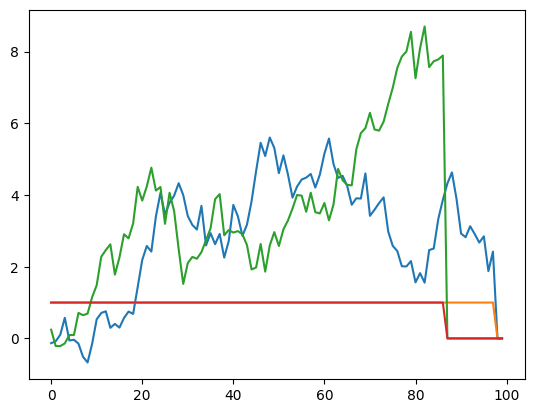

In [37]:
plt.plot(seqs[0])
plt.plot(seqs[10])

In [38]:
cs.sum()/len(cs)

0.481